In [2]:
import tensorflow as tf
import os
import keras
import numpy as np
import easygdf
import mne
import json
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, MaxPooling1D, Dropout, Flatten
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import get_data
from sklearn.model_selection import train_test_split
from colabcode import ColabCode
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

The network

In [ ]:
# Define the squeeze excitation block function
def squeeze_excitation_block(inputs, r):
    filters = inputs.shape[-1]
    se = layers.GlobalAveragePooling1D()(inputs)
    se = layers.Dense(filters // r, activation='relu')(se)
    se = layers.Dense(filters, activation='sigmoid')(se)
    se = layers.Reshape((1, filters))(se)
    out=inputs * se
    return out

# def SqueezeAndExcitation(inputs, ratio=8): 
#     b, _, _, c = inputs.shape 
#     x = GlobalAveragePooling2D()(inputs) 
#     x = Dense(c//ratio, activation="relu", use_bias=False)(x) 
#     x = Dense(c, activation="sigmoid", use_bias=False)(x) 
#     x = inputs * x 
#     return x 

# Set random seed for reproducibility
tf.random.set_seed(1234)

# Define input shape
input_shape = (1000,22)

# Define input layers for each branch
input_1 = tf.keras.Input(shape=input_shape)
input_2 = tf.keras.Input(shape=input_shape)
input_3 = tf.keras.Input(shape=input_shape)

# First Branch
x1 = tf.keras.layers.Conv1D(32, 20, strides=2, padding='same', kernel_regularizer=l2(0.01))(input_1)
x1 = tf.keras.layers.BatchNormalization()(x1)
x1 = tf.keras.layers.ELU()(x1)
x1 = squeeze_excitation_block(x1, r=8)
x1 = tf.keras.layers.MaxPooling1D()(x1)



x1 = tf.keras.layers.Conv1D(32, 9, strides=2, padding='same', kernel_regularizer=l2(0.01))(x1)
x1 = tf.keras.layers.BatchNormalization()(x1)
x1 = tf.keras.layers.ELU()(x1)
x1 = squeeze_excitation_block(x1, r=8)
x1 = tf.keras.layers.MaxPooling1D()(x1)
skip_connection1 = x1 ############

x1 = tf.keras.layers.Conv1D(32, 5, strides=1, padding='same', kernel_regularizer=l2(0.01))(x1)
x1 = tf.keras.layers.BatchNormalization()(x1)
x1 = tf.keras.layers.ELU()(x1)

x1 = tf.keras.layers.Conv1D(32, 5, strides=1, padding='same', kernel_regularizer=l2(0.01))(x1)
x1 = tf.keras.layers.BatchNormalization()(x1)
x1 = tf.keras.layers.ELU()(x1)
x1 = squeeze_excitation_block(x1, r=8)
x1 = tf.keras.layers.add([x1, skip_connection1])############
x1 = tf.keras.layers.MaxPooling1D()(x1)
skip_connection2 = x1 ############

x1 = tf.keras.layers.Conv1D(32, 3, strides=1, padding='same', kernel_regularizer=l2(0.01))(x1)
x1 = tf.keras.layers.BatchNormalization()(x1)
x1 = tf.keras.layers.ELU()(x1)

x1 = tf.keras.layers.Conv1D(32, 3, strides=1, padding='same', kernel_regularizer=l2(0.01))(x1)
x1 = tf.keras.layers.BatchNormalization()(x1)
x1 = tf.keras.layers.ELU()(x1)
x1 = squeeze_excitation_block(x1, r=8)
x1 = tf.keras.layers.add([x1, skip_connection2])############
x1 = tf.keras.layers.MaxPooling1D()(x1)
x1 = tf.keras.layers.Dropout(0.5)(x1)

x1 = tf.keras.layers.Flatten()(x1)

# Second Branch
x2 = tf.keras.layers.Conv1D(32, 13, strides=2, padding='same', kernel_regularizer=l2(0.01))(input_2)
x2 = tf.keras.layers.BatchNormalization()(x2)
x2 = tf.keras.layers.ELU()(x2)
x2 = squeeze_excitation_block(x2, r=8)

x2 = tf.keras.layers.Conv1D(32, 7, strides=2, padding='same', kernel_regularizer=l2(0.01))(x2)
x2 = tf.keras.layers.BatchNormalization()(x2)
x2 = tf.keras.layers.ELU()(x2)
x2 = squeeze_excitation_block(x2, r=8)
x2 = tf.keras.layers.MaxPooling1D()(x2)

x2 = tf.keras.layers.Conv1D(32, 5, strides=1, padding='same', kernel_regularizer=l2(0.01))(x2)
x2 = tf.keras.layers.BatchNormalization()(x2)
x2 = tf.keras.layers.ELU()(x2)
x2 = squeeze_excitation_block(x2, r=8)
x2 = tf.keras.layers.MaxPooling1D()(x2)
skip_connection3 = x2

x2 = tf.keras.layers.Conv1D(32, 3, strides=1, padding='same', kernel_regularizer=l2(0.01))(x2)
x2 = tf.keras.layers.BatchNormalization()(x2)
x2 = tf.keras.layers.ELU()(x2)

x2 = tf.keras.layers.Conv1D(32, 3, strides=1, padding='same', kernel_regularizer=l2(0.01))(x2)
x2 = tf.keras.layers.BatchNormalization()(x2)
x2 = tf.keras.layers.ELU()(x2)
x2 = squeeze_excitation_block(x2, r=8)
x2 = tf.keras.layers.add([x2, skip_connection3])############
x2 = tf.keras.layers.MaxPooling1D()(x2)

x2 = tf.keras.layers.Dropout(0.5)(x2)

x2 = tf.keras.layers.Flatten()(x2)

# Third Branch
x3 = tf.keras.layers.Conv1D(32, 15, strides=2, padding='same', kernel_regularizer=l2(0.01))(input_3)
x3 = tf.keras.layers.BatchNormalization()(x3)
x3 = tf.keras.layers.ELU()(x3)
x3 = squeeze_excitation_block(x3, r=8)
x3 = tf.keras.layers.MaxPooling1D()(x3)

x3 = tf.keras.layers.Conv1D(32, 10, strides=2, padding='same', kernel_regularizer=l2(0.01))(x3)
x3 = tf.keras.layers.BatchNormalization()(x3)
x3 = tf.keras.layers.ELU()(x3)
x3 = squeeze_excitation_block(x3, r=8)

x3 = tf.keras.layers.Conv1D(32, 5, strides=1, padding='same', kernel_regularizer=l2(0.01))(x3)
x3 = tf.keras.layers.BatchNormalization()(x3)
x3 = tf.keras.layers.ELU()(x3)
x3 = squeeze_excitation_block(x3, r=8)
x3 = tf.keras.layers.MaxPooling1D()(x3)

x3 = tf.keras.layers.Conv1D(48, 3, strides=1, padding='same', kernel_regularizer=l2(0.01))(x3)
x3 = tf.keras.layers.BatchNormalization()(x3)
x3 = tf.keras.layers.ELU()(x3)
x3 = squeeze_excitation_block(x3, r=8)
x3 = tf.keras.layers.MaxPooling1D()(x3)

x3 = tf.keras.layers.Dropout(0.5)(x3)

x3 = tf.keras.layers.Flatten()(x3)

# Concatenate the outputs of three branches
merged = tf.keras.layers.concatenate([x1, x2, x3])




#fc1 = tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001))(merged)
#fc2 = tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001))(fc1)

# Dropout layer
x = tf.keras.layers.Dropout(0.5)(merged)

# # Flatten layer
# x = layers.Flatten()(x)

# # Dense layer
# x = layers.Dense(64, activation='relu')(x)

# Output layer
output = tf.keras.layers.Dense(4, activation='softmax')(x)

# Create model
model = Model(inputs=[input_1, input_2, input_3], outputs=output)

# Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Get events and their positions and also get eeg data 

In [ ]:
events_with_labels_arrays=get_data.event_position()

data_arrays=get_data.save_data_in_array()


In [29]:
def create_training_data(data_arrays,events_with_labels_arrays):
    labels = ["A01T","A02T", "A03T","A04T","A05T","A06T","A07T","A08T","A09T"]

    train_data=[]

    for label in labels:

        temp_data=data_arrays[label]
        temp_events=events_with_labels_arrays[label]
        for i in range(len(temp_events)):
        
            if temp_events[i,1]==769 or temp_events[i,1]==770 or temp_events[i,1]==771 or temp_events[i,1]==772 :

                ev=temp_events[i,1]
                position=temp_events[i,0]
                # nth_sample=[]
                # for j in range(position, position+1000):
                #     if j==position+999:
                #         for k in range(1,23):
                #             nth_sample.append(temp_data[j,k])

                #         nth_sample.append(ev)    
                #         break
                #     for k in range(1,23):
                #         nth_sample.append(temp_data[j,k])
                sample=temp_data[position:position+1000,1:23]

                train_data.append((sample,ev))

    return train_data        

create train data

In [30]:

#add label for each row as last column
train_data=create_training_data(data_arrays,events_with_labels_arrays)


In [31]:
X, Y = zip(*train_data)
X=np.array(X)
Y=np.array(Y)

Y = Y.reshape(-1, 1)

do interpolation

In [32]:
from scipy.interpolate import interp1d

# Create an empty array to store the interpolated data
final_interpolated_data = np.zeros((X.shape[0], 1050, X.shape[2]))

# Perform interpolation for each sample separately
for sample_idx in range(X.shape[0]):
    # Get the EEG data for the current sample
    sample_data = X[sample_idx, :, :]

    # Create an empty array to store the interpolated sample data
    interpolated_sample_data = np.zeros((1050, X.shape[2]))

    # Perform interpolation for each channel separately
    for channel in range(X.shape[2]):
        # Get the EEG data for the current channel
        channel_data = sample_data[:, channel]

        # Create an interpolation function for the current channel
        interp_func = interp1d(np.arange(1000), channel_data, kind='linear')

        # Interpolate the data to increase the number of samples to 1050
        interpolated_channel_data = interp_func(np.linspace(0, 999, 1050))

        # Store the interpolated data for the current channel
        interpolated_sample_data[:, channel] = interpolated_channel_data

    # Assign the interpolated sample data to the final array
    final_interpolated_data[sample_idx, :, :] = interpolated_sample_data


do cropping

In [33]:
# Initialize empty lists to store cropped segments and corresponding labels
cropped_segments = []
segment_labels = []

# Iterate over each sample
for sample_idx in range(final_interpolated_data.shape[0]):
    # Get the EEG data for the current sample
    sample_data = final_interpolated_data[sample_idx, :, :]
    # Get the labels for the current sample
    sample_labels = Y[sample_idx]
    # Calculate the number of segments
    num_segments = (sample_data.shape[0] - 1000) // 10 + 1
    # Iterate over each segment
    for segment_idx in range(num_segments):
        # Calculate start index of the segment
        start_idx = segment_idx * 10
        # Extract the segment
        segment = sample_data[start_idx:start_idx + 1000, :]
        # Append the segment to the list of cropped segments
        cropped_segments.append(segment)
        # Extract the label for the segment
        segment_label = sample_labels
        # Append the label to the list of segment labels
        segment_labels.append(segment_label)

# Convert the lists to numpy arrays
cropped_segments = np.array(cropped_segments)
segment_labels = np.array(segment_labels)

concatenating

In [34]:
X = np.concatenate((X, cropped_segments), axis=0)
Y = np.concatenate((Y, segment_labels), axis=0)

In [35]:
print("nima")

nima


create X and Y

In [76]:

#convert train_data to np array
# train_data = np.array(train_data)

# #Separate features (X) and labels (y)
# X = train_data[:, :-1]  # Extract all rows and all columns except the last one
# Y = train_data[:, -1]   # Extract all rows and only the last column

# #reshape Y to 2d array
# Y = Y.reshape(-1, 1)


Match each events to 0-3 class

In [17]:
for i in range(len(Y)):
    if Y[i]==769:
        Y[i]=0
    elif Y[i]==770:
        Y[i]=1
    elif Y[i]==771:
        Y[i]=2    
    elif Y[i]==772:
        Y[i]=3    
    

Shuffle X and Y train

In [18]:
#Generate shuffled indices
indices = np.arange(len(X))
np.random.shuffle(indices)

# Shuffle x_train and y_train using the shuffled indices
X = X[indices]
Y = Y[indices]



Split data to test and train

In [19]:
x_train, x_ , y_train, y_ =train_test_split(X, Y, test_size=0.20, random_state=1)

x_cv, x_test, y_cv, y_test =train_test_split(x_, y_, test_size=0.50, random_state=1)

# del x_ ,y_

define early stop class and function

In [24]:
from keras.callbacks import Callback

class EarlyStopAtAccuracy(Callback):
    def __init__(self, monitor='val_accuracy', target_accuracy=0.93, patience=0, verbose=0, mode='auto'):
        super(EarlyStopAtAccuracy, self).__init__()
        self.monitor = monitor
        self.target_accuracy = target_accuracy
        self.patience = patience
        self.verbose = verbose
        self.wait = 0
        self.stopped_epoch = 0
        self.mode = mode
        if mode == 'auto':
            if 'acc' in self.monitor:
                self.mode = 'max'
            else:
                self.mode = 'min'

    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get(self.monitor)
        if current_accuracy is None:
            print("Early stopping requires %s available!" % self.monitor, 'WARNING')
            return

        if self.mode == 'max':
            improvement = (current_accuracy - self.target_accuracy) / self.target_accuracy
        else:
            improvement = (self.target_accuracy - current_accuracy) / self.target_accuracy

        if improvement >= 0:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                if self.verbose > 0:
                    print('Epoch %05d: early stopping at accuracy %.2f' % (epoch, self.target_accuracy))
        else:
            self.wait = 0



Train the model

Epoch 1/54
208/208 [==============================] - 75s 252ms/step - loss: 6.0058 - accuracy: 0.3111 - val_loss: 4.7842 - val_accuracy: 0.4807
Epoch 2/54
208/208 [==============================] - 48s 233ms/step - loss: 4.3139 - accuracy: 0.4705 - val_loss: 3.5518 - val_accuracy: 0.5766
Epoch 3/54
208/208 [==============================] - 45s 217ms/step - loss: 3.1703 - accuracy: 0.5512 - val_loss: 2.6087 - val_accuracy: 0.6499
Epoch 4/54
208/208 [==============================] - 47s 228ms/step - loss: 2.3502 - accuracy: 0.6245 - val_loss: 1.9656 - val_accuracy: 0.6907
Epoch 5/54
208/208 [==============================] - 48s 232ms/step - loss: 1.7940 - accuracy: 0.6732 - val_loss: 1.5547 - val_accuracy: 0.7216
Epoch 6/54
208/208 [==============================] - 43s 207ms/step - loss: 1.4337 - accuracy: 0.7121 - val_loss: 1.2501 - val_accuracy: 0.7596
Epoch 7/54
208/208 [==============================] - 43s 209ms/step - loss: 1.1968 - accuracy: 0.7417 - val_loss: 1.1755 - val_ac

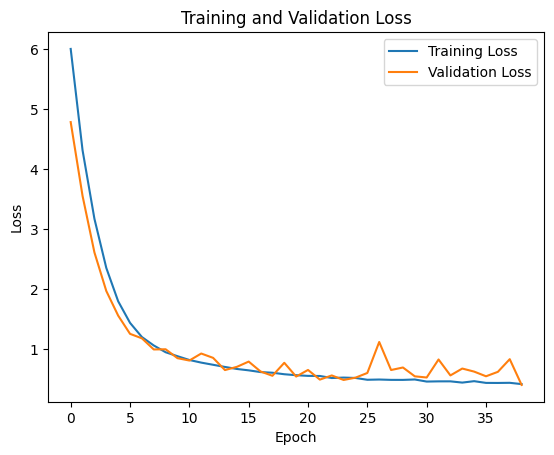

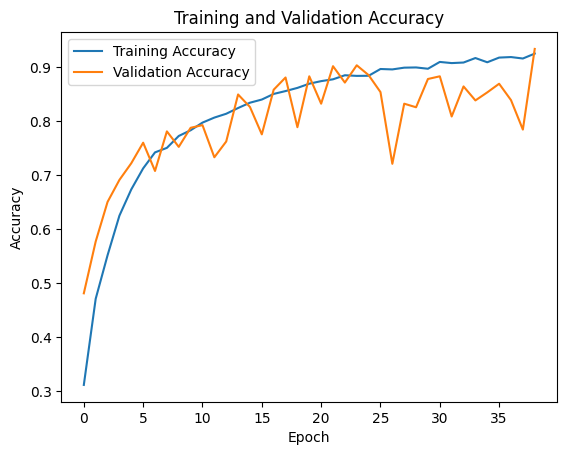

In [26]:
checkpoint = ModelCheckpoint("model_checkpoint.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
#early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
early_stopping = EarlyStopAtAccuracy(monitor='val_accuracy', target_accuracy=0.93, patience=0, verbose=1, mode='max')

# Train the model
history = model.fit(
    [x_train, x_train, x_train], y_train,
    epochs=54,
    batch_size=70,
    validation_data=([x_cv, x_cv, x_cv], y_cv),
    callbacks=[early_stopping]
)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [27]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate([x_test, x_test, x_test], y_test, verbose=0)

# Predict labels for the test set
y_pred = model.predict([x_test, x_test, x_test])

# Convert predicted probabilities to labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate F1 score
f1 = f1_score(y_test, y_pred_labels, average='weighted')

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')
print(f'Test F1 Score: {f1}')

57/57 [==============================] - 3s 22ms/step
Test Loss: 0.417237788438797
Test Accuracy: 0.9217630624771118
Test F1 Score: 0.9218237788183593


In [70]:
# Train the model
history=model.fit([x_train, x_train, x_train], y_train, epochs=100, batch_size=2, validation_split=0.2)

# Plot the training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show() 



Epoch 1/100
 59/184 [========>.....................] - ETA: 14s - loss: 4.2015 - accuracy: 0.7119

KeyboardInterrupt: 

In [62]:
# X_train_reshaped = x_train.reshape(-1, 22000)
# X_val_reshaped = x_cv.reshape(-1, 22000)
# X_test_reshaped = x_test.reshape(-1, 22000)

# # Initialize MinMaxScaler
# scaler = MinMaxScaler()

# # Fit scaler on training data and transform training, validation, and test data
# X_train_normalized = scaler.fit_transform(X_train_reshaped)
# X_val_normalized = scaler.transform(X_val_reshaped)
# X_test_normalized = scaler.transform(X_test_reshaped)

# # Reshape normalized data back to the original shape
# x_train_normalized = X_train_normalized.reshape(-1, 22000, 1)
# x_val_normalized = X_val_normalized.reshape(-1, 22000, 1)
# x_test_normalized = X_test_normalized.reshape(-1, 22000, 1)